> 🩺 Este notebook forma parte del proyecto **NutriSynthCare**, un entorno de simulación sobre salud pública y recomendaciones nutricionales personalizadas.  
>
> 👥 Desarrollado por:  
> - Daniel Cruz – [dCruzCoding](https://github.com/dCruzCoding)  
> - Aníbal García – [Aniballll](https://github.com/Aniballll)  
>
> 📁 Repositorio completo: [NutriSynthCare](https://github.com/dCruzCoding/NutriSynthCare)  
>
> 📜 Licencia: Este proyecto está disponible bajo la licencia MIT. Consulta el archivo `LICENSE` para más información.  
>
> 🙏 Agradecimientos especiales a todas las fuentes de datos y literatura científica que han hecho posible la creación de las bases sintéticas utilizadas en este proyecto.  
>
> 🤝 ¿Te interesa colaborar? ¡Estás invitado!  
> Puedes contribuir mejorando los notebooks, proponiendo nuevas ideas o corrigiendo errores:  
> - Haz un fork del repo  
> - Crea una rama (`git checkout -b mejora/nueva-idea`)  
> - Abre un Pull Request explicando tu propuesta

# =========================================================================
# ⚙️ PIPELINE DE LA GENERACIÓN DE LA BASE DE DATOS
# RIESGO CARDIOVASCULAR ❤️ EN PERSONAS CON DIABETES 🩸
# =========================================================================

```text
+---------------------------------+      +-----------------------------------------+
|    DB Sintética 1: Diabetes     |      |  DB Sintética 2: Riesgo Cardiovascular  |
+---------------------------------+      +-----------------------------------------+
             |                                              |
             '--------------------. .-----------------------'
                                  |
                                  v
                  +--------------------------------+
                  |    1. UNIÓN DE BASES DE DATOS  |
                  |     (Outer Join por columnas   |
                  |           comunes)             |
                  +--------------------------------+
                                  |
                                  v
        +---------------------------------------------------------+
        |         Dataset Combinado con Valores Faltantes (NaN)   |
        +---------------------------------------------------------+
                                  |
                                  v
+----------------------------------------------------------------------------------+
|               2. PROCESO DE IMPUTACIÓN SECUENCIAL Y CONDICIONAL                  |
|                                                                                  |
|   +--------------------------------------------------------------------------+   |
|   |   FASE 1: IMPUTACIÓN DE VARIABLES NUMÉRICAS                              |   |
|   |   (HbA1c, Insulina, HDL, LDL, etc.)                                      |   |
|   |   +------------------------------------------------------------------+   |
|   |   | - Análisis de correlación para cada variable.                    |   |
|   |   | - SI hay relación fuerte -> Imputar con REGRESIÓN LINEAL MÚLTIPLE. |   |
|   |   | - SI NO hay relación   -> EXCLUIR VARIABLE para evitar ruido.     |   |
|   |   +------------------------------------------------------------------+   |
|   +--------------------------------------------------------------------------+
|                                     |
|                                     v
|   +--------------------------------------------------------------------------+
|   |   FASE 2: IMPUTACIÓN DE VARIABLES CATEGÓRICAS (En tres etapas)           |
|   |                                                                          |
|   |   --> ETAPA 2.1: Variables de Contexto (Actividad, Estrés, etc.)         |
|   |   |   +--------------------------------------------------------------+   |
|   |   |   | Se imputan primero con un clasificador (ej. XGBoost) si      |   |
|   |   |   | muestran asociación suficiente.                              |   |
|   |   |   +--------------------------------------------------------------+   |
|   |                                     |                                    |
|   |                                     v                                    |
|   |                                                                          |
|   |   --> ETAPA 2.2: Variable Clave -> Tipo_Diabetes                         |
|   |   |   +--------------------------------------------------------------+   |
|   |   |   | Se entrena un RandomForestClassifier para una imputación     |   |
|   |   |   | precisa, basada en las variables más relevantes.             |   |
|   |   |   +--------------------------------------------------------------+   |
|   |                                     |                                    |
|   |                                     v                                    |
|   |                                                                          |
|   |   --> ETAPA 2.3: Variable Clave -> Riesgo_Cardiovascular                 |
|   |    +--------------------------------------------------------------+      |
|   |    | 1. Se entrena un modelo XGBoost optimizado.                  |      |
|   |    | 2. Se realiza una búsqueda de hiperparámetros                |      |
|   |    | 3. La variable de 4 niveles ('Bajo', 'Mod', etc.)            |      |
|   |    |    se agrupa en 2 clases ('Bajo' vs 'Riesgo Elevado').       |      |
|   |    +--------------------------------------------------------------+      |
|   |                                                                          |
+------------------------------------------------------------------------------+
                                     |
                                     v
                  +--------------------------------------+
                  |    DATASET FINAL IMPUTADO (PARCIAL)  |
                  | (Algunas variables pueden haber sido |
                  | excluidas si no cumplían criterios)  |
                  |   (Listo para análisis y modelado)   |
                  +--------------------------------------+

In [3]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Reproducibilidad
np.random.seed(42)

warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Cargamos los csv y lo convertimos en dataframe
df = pd.read_csv("db_cardiabetes.csv")

display(df)

,Año_Registro,Edad,IMC,Diabetes,Colesterol_Total,Trigliceridos,PAS,PAD,Cohorte,HbA1c,Insulina,LDL,HDL,Nivel_Estres,Actividad_Fisica,Riesgo_Cardiovascular,Sexo,Tipo_Diabetes,Tipo_Diabetes_imputada
0,2016,-0.804483,-0.362909,0,203.053597,-0.525838,-1.113528,-1.128432,cardio,5.483777,10.602855,111.284292,71.456754,Alto,Moderado,Bajo,Hombre,No diabetes,No diabetes
1,2013,1.050480,-2.271737,0,214.198250,0.114886,-0.658882,-1.507895,cardio,5.212008,56.952216,124.064267,48.292897,Moderado,Sedentario,Bajo,Mujer,No diabetes,No diabetes
2,2017,1.335859,0.097390,0,178.338545,-0.998805,-0.187398,-1.371288,cardio,6.750564,92.875636,123.757918,55.659980,Moderado,Moderado,Bajo,Mujer,Diabetes latente,Diabetes latente
3,2014,0.194343,1.868184,0,208.059981,-0.049786,1.336506,-0.308793,cardio,4.659614,188.637574,110.158158,54.487884,Moderado,Sedentario,Bajo,Mujer,Diabetes latente,Diabetes latente
4,2016,0.337033,-0.081596,1,260.781259,0.017413,0.418796,-0.490935,cardio,7.436320,66.564019,120.410972,52.990636,Moderado,Sedentario,Moderado,Mujer,NaN,Diabetes latente
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15944,2017,-0.634414,-0.096697,1,210.750000,-0.361928,-0.692497,-0.478777,diabetes,5.840000,4.450000,96.230000,53.870000,Bajo,Moderado,NaN,Hombre,Tipo 1,Tipo 1
15945,2012,-0.809270,0.745440,1,226.150000,0.743030,-0.274150,0.519960,diabetes,7.810000,79.930000,107.710000,43.000000,Alto,Moderado,NaN,Hombre,Tipo 2,Tipo 2
15946,2012,-0.109843,-0.426947,1,215.130000,-1.201495,-0.632733,-0.349528,diabetes,7.370000,12.610000,103.980000,50.240000,Bajo,Activo,NaN,Hombre,Tipo 1,Tipo 1
15947,2016,1.376441,-1.170009,1,228.540000,0.106274,0.436374,-0.373028,diabetes,8.100000,0.390000,108.890000,54.810000,Alto,Sedentario,NaN,Mujer,Tipo 1,Tipo 1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15949 entries, 0 to 15948
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Año_Registro            15949 non-null  int64  
 1   Edad                    15949 non-null  float64
 2   IMC                     15949 non-null  float64
 3   Diabetes                15949 non-null  int64  
 4   Colesterol_Total        15949 non-null  float64
 5   Trigliceridos           15949 non-null  float64
 6   PAS                     15949 non-null  float64
 7   PAD                     15949 non-null  float64
 8   Cohorte                 15949 non-null  object 
 9   HbA1c                   15949 non-null  float64
 10  Insulina                15949 non-null  float64
 11  LDL                     15949 non-null  float64
 12  HDL                     15949 non-null  float64
 13  Nivel_Estres            15949 non-null  object 
 14  Actividad_Fisica        15949 non-null

In [6]:
# Eliminar la columna 'Tipo_Diabetes' y renombrar 'Tipo_Diabetes_imputada' a 'TIPD'
df = df.drop(columns=['Tipo_Diabetes'])
df = df.rename(columns={'Tipo_Diabetes_imputada': 'Tipo_Diabetes'})

In [7]:
df['Riesgo_Cardiovascular'].describe()

count     7962
unique       4
top       Bajo
freq      3664
Name: Riesgo_Cardiovascular, dtype: object

In [8]:
# Mostrar información y valores únicos de la columna 'Riesgo_Cardiovascular'
print("Valores únicos de 'Riesgo_Cardiovascular':")
print(df['Riesgo_Cardiovascular'].unique())
print("\nConteo por categoría:")
print(df['Riesgo_Cardiovascular'].value_counts(dropna=False))

Valores únicos de 'Riesgo_Cardiovascular':
['Bajo' 'Moderado' 'Muy Alto' 'Alto' nan]

Conteo por categoría:
Riesgo_Cardiovascular
NaN         7987
Bajo        3664
Alto        2042
Moderado    1414
Muy Alto     842
Name: count, dtype: int64


In [9]:
df.columns

Index(['Año_Registro', 'Edad', 'IMC', 'Diabetes', 'Colesterol_Total',
       'Trigliceridos', 'PAS', 'PAD', 'Cohorte', 'HbA1c', 'Insulina', 'LDL',
       'HDL', 'Nivel_Estres', 'Actividad_Fisica', 'Riesgo_Cardiovascular',
       'Sexo', 'Tipo_Diabetes'],
      dtype='object')

In [10]:
# Variables categóricas y sus valores únicos
categorical_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns
print("Variables categóricas y sus valores únicos:")
for col in categorical_cols:
    print(f"> {col}: {df[col].unique()}")

# Variables numéricas
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
print("\nVariables numéricas:")
print(list(numeric_cols))

Variables categóricas y sus valores únicos:
> Cohorte: ['cardio' 'diabetes']
> Nivel_Estres: ['Alto' 'Moderado' 'Bajo']
> Actividad_Fisica: ['Moderado' 'Sedentario' 'Activo']
> Riesgo_Cardiovascular: ['Bajo' 'Moderado' 'Muy Alto' 'Alto' nan]
> Sexo: ['Hombre' 'Mujer']
> Tipo_Diabetes: ['No diabetes' 'Diabetes latente' 'Tipo 2' 'Tipo 1' 'Gestacional']

Variables numéricas:
['Año_Registro', 'Edad', 'IMC', 'Diabetes', 'Colesterol_Total', 'Trigliceridos', 'PAS', 'PAD', 'HbA1c', 'Insulina', 'LDL', 'HDL']


Creando nuevas características (Feature Engineering)...

Paso 1: Selección de variables y división de datos
Total de datos: 15949
Datos para entrenar el modelo: 7962
Datos que necesitan imputación: 7987

Paso 2: Configurando el preprocesamiento de datos

Paso 3: Creando el pipeline XGBoost

Paso 4: Optimizando hiperparámetros para XGBoost (Problema de 2 Clases)

Simplificando el problema: Agrupando a 2 niveles de riesgo (Bajo vs. Elevado).
Distribución de las nuevas clases agrupadas:
Riesgo_Cardiovascular
Riesgo Elevado    4298
Bajo              3664
Name: count, dtype: int64

Nuevo mapeo de clases a números: {'Bajo': 0, 'Riesgo Elevado': 1}
Fitting 3 folds for each of 25 candidates, totalling 75 fits

Mejores parámetros encontrados: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 335, 'classifier__subsample': 0.7}

--- Evaluación del MODELO FINAL (XGBoost - 2 Clases) en el Conjunto de Prueba ---
Accuracy 

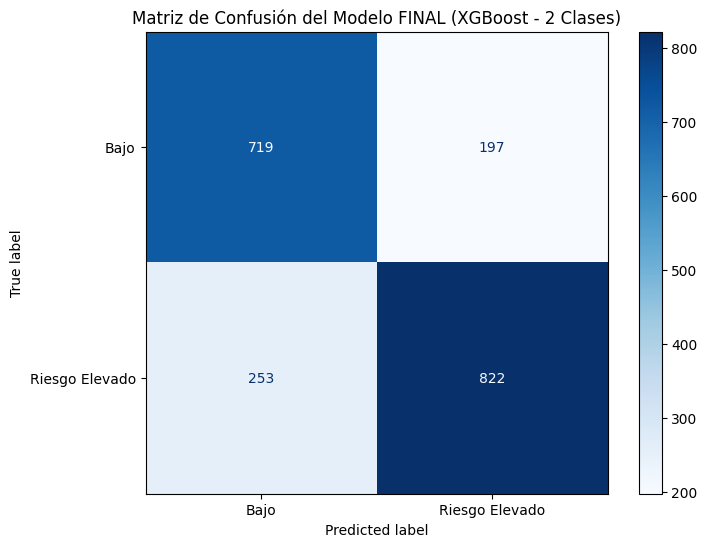


PASO 5: Realizando la imputación (Versión corregida)...
Número de filas a imputar: 7987
Generando predicciones...
Asignando predicciones al DataFrame original...

--- Verificación Post-Imputación ---
NaNs restantes en la columna 'Riesgo_Cardiovascular': 0
¡ÉXITO! Todos los valores NaN han sido imputados correctamente.


In [11]:
# =============================================================================
# PASO 0: Importar librerías y preparar el entorno
# =============================================================================
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import randint

# =============================================================================
# INGENIERÍA DE CARACTERÍSTICAS (FEATURE ENGINEERING)
# =============================================================================
print("Creando nuevas características (Feature Engineering)...")
df['Presion_Pulso'] = df['PAS'] - df['PAD']
df['Ratio_Colesterol'] = (df['Colesterol_Total'] / df['HDL']).replace([np.inf, -np.inf], 0)

# =============================================================================
# PASO 1: Selección de variables y división de datos
# =============================================================================
print("\nPaso 1: Selección de variables y división de datos")
target = 'Riesgo_Cardiovascular'
features_numericas = ['Edad', 'IMC', 'Colesterol_Total', 'Trigliceridos', 'PAS', 'PAD', 'HbA1c', 'Insulina', 'LDL', 'HDL', 'Presion_Pulso', 'Ratio_Colesterol']
features_categoricas = ['Nivel_Estres', 'Actividad_Fisica', 'Sexo', 'Tipo_Diabetes']
features_predictoras = features_numericas + features_categoricas

df['Riesgo_Imputado'] = df[target].isnull()
datos_completos = df[df[target].notna()].copy()
datos_a_imputar = df[df[target].isna()].copy()

print(f"Total de datos: {len(df)}")
print(f"Datos para entrenar el modelo: {len(datos_completos)}")
print(f"Datos que necesitan imputación: {len(datos_a_imputar)}\n")

# =============================================================================
# PASO 2: Preparación del preprocesamiento
# =============================================================================
print("Paso 2: Configurando el preprocesamiento de datos")
normalizadas = ['Edad', 'IMC', 'Trigliceridos', 'PAS', 'PAD']
a_escalar = [col for col in features_numericas if col not in normalizadas]
preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), a_escalar),
        ('cat_onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), features_categoricas)
    ],
    remainder='passthrough'
)

# =============================================================================
# PASO 3: Pipeline XGBoost
# =============================================================================
print("\nPaso 3: Creando el pipeline XGBoost")
pipeline_final = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, n_jobs=-1, eval_metric='mlogloss'))
])

# =============================================================================
# PASO 4: Optimización de Hiperparámetros y Evaluación (VERSIÓN 2 CLASES)
# =============================================================================
print("\nPaso 4: Optimizando hiperparámetros para XGBoost (Problema de 2 Clases)")
param_dist_xgb = {
    'classifier__n_estimators': randint(100, 500), 'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7, 10], 'classifier__subsample': [0.7, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

# --- Preparación de datos para el modelo ---
X = datos_completos[features_predictoras]
y = datos_completos[target]

# --- AQUÍ LA NUEVA AGRUPACIÓN A 2 CLASES ---
print("\nSimplificando el problema: Agrupando a 2 niveles de riesgo (Bajo vs. Elevado).")
mapeo_agrupacion_2_clases = {
    'Bajo': 'Bajo',
    'Moderado': 'Riesgo Elevado',
    'Alto': 'Riesgo Elevado',
    'Muy Alto': 'Riesgo Elevado'
}
y_agrupada = y.map(mapeo_agrupacion_2_clases)

mapeo_logico_2_clases = {'Bajo': 0, 'Riesgo Elevado': 1}
y_encoded = y_agrupada.map(mapeo_logico_2_clases)

print("Distribución de las nuevas clases agrupadas:")
print(y_agrupada.value_counts())
print("\nNuevo mapeo de clases a números:", mapeo_logico_2_clases)

# Usar 'y_encoded' (ahora con 2 clases) para el split y el entrenamiento
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
    X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded
)

# --- Búsqueda de Hiperparámetros ---
random_search_xgb = RandomizedSearchCV(
    pipeline_final, param_distributions=param_dist_xgb, n_iter=25, cv=3,
    scoring='f1_weighted', n_jobs=-1, random_state=42, verbose=1
)
random_search_xgb.fit(X_train, y_train_encoded)

# --- Evaluación del Mejor Modelo ---
mejor_modelo_final = random_search_xgb.best_estimator_
print(f"\nMejores parámetros encontrados: {random_search_xgb.best_params_}")
y_pred_encoded = mejor_modelo_final.predict(X_test)

print("\n--- Evaluación del MODELO FINAL (XGBoost - 2 Clases) en el Conjunto de Prueba ---")
print(f"Accuracy (Exactitud): {accuracy_score(y_test_encoded, y_pred_encoded):.4f}")
print("\nReporte de Clasificación Final:")
print(classification_report(y_test_encoded, y_pred_encoded, target_names=list(mapeo_logico_2_clases.keys())))

# --- Visualización ---
print("Generando Matriz de Confusión Final...")
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(
    mejor_modelo_final, X_test, y_test_encoded, ax=ax, cmap='Blues', display_labels=list(mapeo_logico_2_clases.keys())
)
plt.title('Matriz de Confusión del Modelo FINAL (XGBoost - 2 Clases)')
plt.show()

# =============================================================================
# PASO 5: IMPUTACIÓN CORREGIDA (VERSIÓN ROBUSTA)
# =============================================================================
print("\nPASO 5: Realizando la imputación (Versión corregida)...")

# 1. Identificar las filas con NaN en la columna objetivo
filas_a_imputar = df[df[target].isnull()].copy()
print(f"Número de filas a imputar: {len(filas_a_imputar)}")

if len(filas_a_imputar) > 0:
    # 2. Extraer las características de las filas a imputar
    X_para_predecir = filas_a_imputar[features_predictoras]
    
    # 3. Hacer predicciones con el modelo entrenado
    print("Generando predicciones...")
    predicciones_numericas = mejor_modelo_final.predict(X_para_predecir)
    
    # 4. Decodificar las predicciones numéricas a texto
    mapeo_inverso = {v: k for k, v in mapeo_logico_2_clases.items()}
    predicciones_texto = [mapeo_inverso[pred] for pred in predicciones_numericas]
    
    # 5. Asignar las predicciones al DataFrame original
    print("Asignando predicciones al DataFrame original...")
    # Usamos .loc con los índices originales de las filas a imputar
    df.loc[filas_a_imputar.index, target] = predicciones_texto
    
    # 6. Verificación final
    print("\n--- Verificación Post-Imputación ---")
    nans_restantes = df[target].isnull().sum()
    print(f"NaNs restantes en la columna '{target}': {nans_restantes}")
    
    if nans_restantes == 0:
        print("¡ÉXITO! Todos los valores NaN han sido imputados correctamente.")
    else:
        print("¡ADVERTENCIA! Quedan valores NaN. Revisar los índices.")
        # Imprimir filas con NaN restantes para diagnóstico
        print("\nFilas con NaN restantes:")
        print(df[df[target].isnull()][[target] + features_predictoras])
else:
    print("No hay valores NaN para imputar.")


In [12]:
df

,Año_Registro,Edad,IMC,Diabetes,Colesterol_Total,Trigliceridos,PAS,PAD,Cohorte,HbA1c,...,LDL,HDL,Nivel_Estres,Actividad_Fisica,Riesgo_Cardiovascular,Sexo,Tipo_Diabetes,Presion_Pulso,Ratio_Colesterol,Riesgo_Imputado
0,2016,-0.804483,-0.362909,0,203.053597,-0.525838,-1.113528,-1.128432,cardio,5.483777,...,111.284292,71.456754,Alto,Moderado,Bajo,Hombre,No diabetes,0.014904,2.841629,False
1,2013,1.050480,-2.271737,0,214.198250,0.114886,-0.658882,-1.507895,cardio,5.212008,...,124.064267,48.292897,Moderado,Sedentario,Bajo,Mujer,No diabetes,0.849012,4.435399,False
2,2017,1.335859,0.097390,0,178.338545,-0.998805,-0.187398,-1.371288,cardio,6.750564,...,123.757918,55.659980,Moderado,Moderado,Bajo,Mujer,Diabetes latente,1.183890,3.204071,False
3,2014,0.194343,1.868184,0,208.059981,-0.049786,1.336506,-0.308793,cardio,4.659614,...,110.158158,54.487884,Moderado,Sedentario,Bajo,Mujer,Diabetes latente,1.645299,3.818463,False
4,2016,0.337033,-0.081596,1,260.781259,0.017413,0.418796,-0.490935,cardio,7.436320,...,120.410972,52.990636,Moderado,Sedentario,Moderado,Mujer,Diabetes latente,0.909731,4.921271,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15944,2017,-0.634414,-0.096697,1,210.750000,-0.361928,-0.692497,-0.478777,diabetes,5.840000,...,96.230000,53.870000,Bajo,Moderado,Bajo,Hombre,Tipo 1,-0.213720,3.912196,True
15945,2012,-0.809270,0.745440,1,226.150000,0.743030,-0.274150,0.519960,diabetes,7.810000,...,107.710000,43.000000,Alto,Moderado,Riesgo Elevado,Hombre,Tipo 2,-0.794110,5.259302,True
15946,2012,-0.109843,-0.426947,1,215.130000,-1.201495,-0.632733,-0.349528,diabetes,7.370000,...,103.980000,50.240000,Bajo,Activo,Bajo,Hombre,Tipo 1,-0.283205,4.282046,True
15947,2016,1.376441,-1.170009,1,228.540000,0.106274,0.436374,-0.373028,diabetes,8.100000,...,108.890000,54.810000,Alto,Sedentario,Riesgo Elevado,Mujer,Tipo 1,0.809402,4.169677,True


In [13]:
# Mostrar información y valores únicos de la columna 'Riesgo_Cardiovascular'
print("Valores únicos de 'Riesgo_Cardiovascular':")
print(df['Riesgo_Cardiovascular'].unique())
print("\nConteo por categoría:")
print(df['Riesgo_Cardiovascular'].value_counts(dropna=False))

Valores únicos de 'Riesgo_Cardiovascular':
['Bajo' 'Moderado' 'Muy Alto' 'Alto' 'Riesgo Elevado']

Conteo por categoría:
Riesgo_Cardiovascular
Bajo              7507
Riesgo Elevado    4144
Alto              2042
Moderado          1414
Muy Alto           842
Name: count, dtype: int64


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15949 entries, 0 to 15948
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Año_Registro           15949 non-null  int64  
 1   Edad                   15949 non-null  float64
 2   IMC                    15949 non-null  float64
 3   Diabetes               15949 non-null  int64  
 4   Colesterol_Total       15949 non-null  float64
 5   Trigliceridos          15949 non-null  float64
 6   PAS                    15949 non-null  float64
 7   PAD                    15949 non-null  float64
 8   Cohorte                15949 non-null  object 
 9   HbA1c                  15949 non-null  float64
 10  Insulina               15949 non-null  float64
 11  LDL                    15949 non-null  float64
 12  HDL                    15949 non-null  float64
 13  Nivel_Estres           15949 non-null  object 
 14  Actividad_Fisica       15949 non-null  object 
 15  Ri

In [15]:
# =============================================================================
# Transformación Final
# =============================================================================
print("\nHomogeneizando la columna objetivo y guardando...")

# 1. Convertimos TODA la columna a formato binario para que sea consistente
mapeo_a_binario = {
    'Bajo': 'Bajo',
    'Moderado': 'Riesgo Elevado',
    'Alto': 'Riesgo Elevado',
    'Muy Alto': 'Riesgo Elevado',
    'Riesgo Elevado': 'Riesgo Elevado' 
}
df['Riesgo_Cardiovascular'] = df['Riesgo_Cardiovascular'].map(mapeo_a_binario)
print("\nColumna objetivo transformada a formato binario.")
print(df['Riesgo_Cardiovascular'].value_counts())



Homogeneizando la columna objetivo y guardando...

Columna objetivo transformada a formato binario.
Riesgo_Cardiovascular
Riesgo Elevado    8442
Bajo              7507
Name: count, dtype: int64


In [16]:
# Mostrar información y valores únicos de la columna 'Riesgo_Cardiovascular'
print("Valores únicos de 'Riesgo_Cardiovascular':")
print(df['Riesgo_Cardiovascular'].unique())
print("\nConteo por categoría:")
print(df['Riesgo_Cardiovascular'].value_counts(dropna=False))

Valores únicos de 'Riesgo_Cardiovascular':
['Bajo' 'Riesgo Elevado']

Conteo por categoría:
Riesgo_Cardiovascular
Riesgo Elevado    8442
Bajo              7507
Name: count, dtype: int64


In [17]:
df = df.drop(columns=['Riesgo_Imputado', 'Presion_Pulso', 'Ratio_Colesterol'])

df.info()
df[df['Riesgo_Cardiovascular'].notnull()].count()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15949 entries, 0 to 15948
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Año_Registro           15949 non-null  int64  
 1   Edad                   15949 non-null  float64
 2   IMC                    15949 non-null  float64
 3   Diabetes               15949 non-null  int64  
 4   Colesterol_Total       15949 non-null  float64
 5   Trigliceridos          15949 non-null  float64
 6   PAS                    15949 non-null  float64
 7   PAD                    15949 non-null  float64
 8   Cohorte                15949 non-null  object 
 9   HbA1c                  15949 non-null  float64
 10  Insulina               15949 non-null  float64
 11  LDL                    15949 non-null  float64
 12  HDL                    15949 non-null  float64
 13  Nivel_Estres           15949 non-null  object 
 14  Actividad_Fisica       15949 non-null  object 
 15  Ri

Año_Registro             15949
Edad                     15949
IMC                      15949
Diabetes                 15949
Colesterol_Total         15949
Trigliceridos            15949
PAS                      15949
PAD                      15949
Cohorte                  15949
HbA1c                    15949
Insulina                 15949
LDL                      15949
HDL                      15949
Nivel_Estres             15949
Actividad_Fisica         15949
Riesgo_Cardiovascular    15949
Sexo                     15949
Tipo_Diabetes            15949
dtype: int64

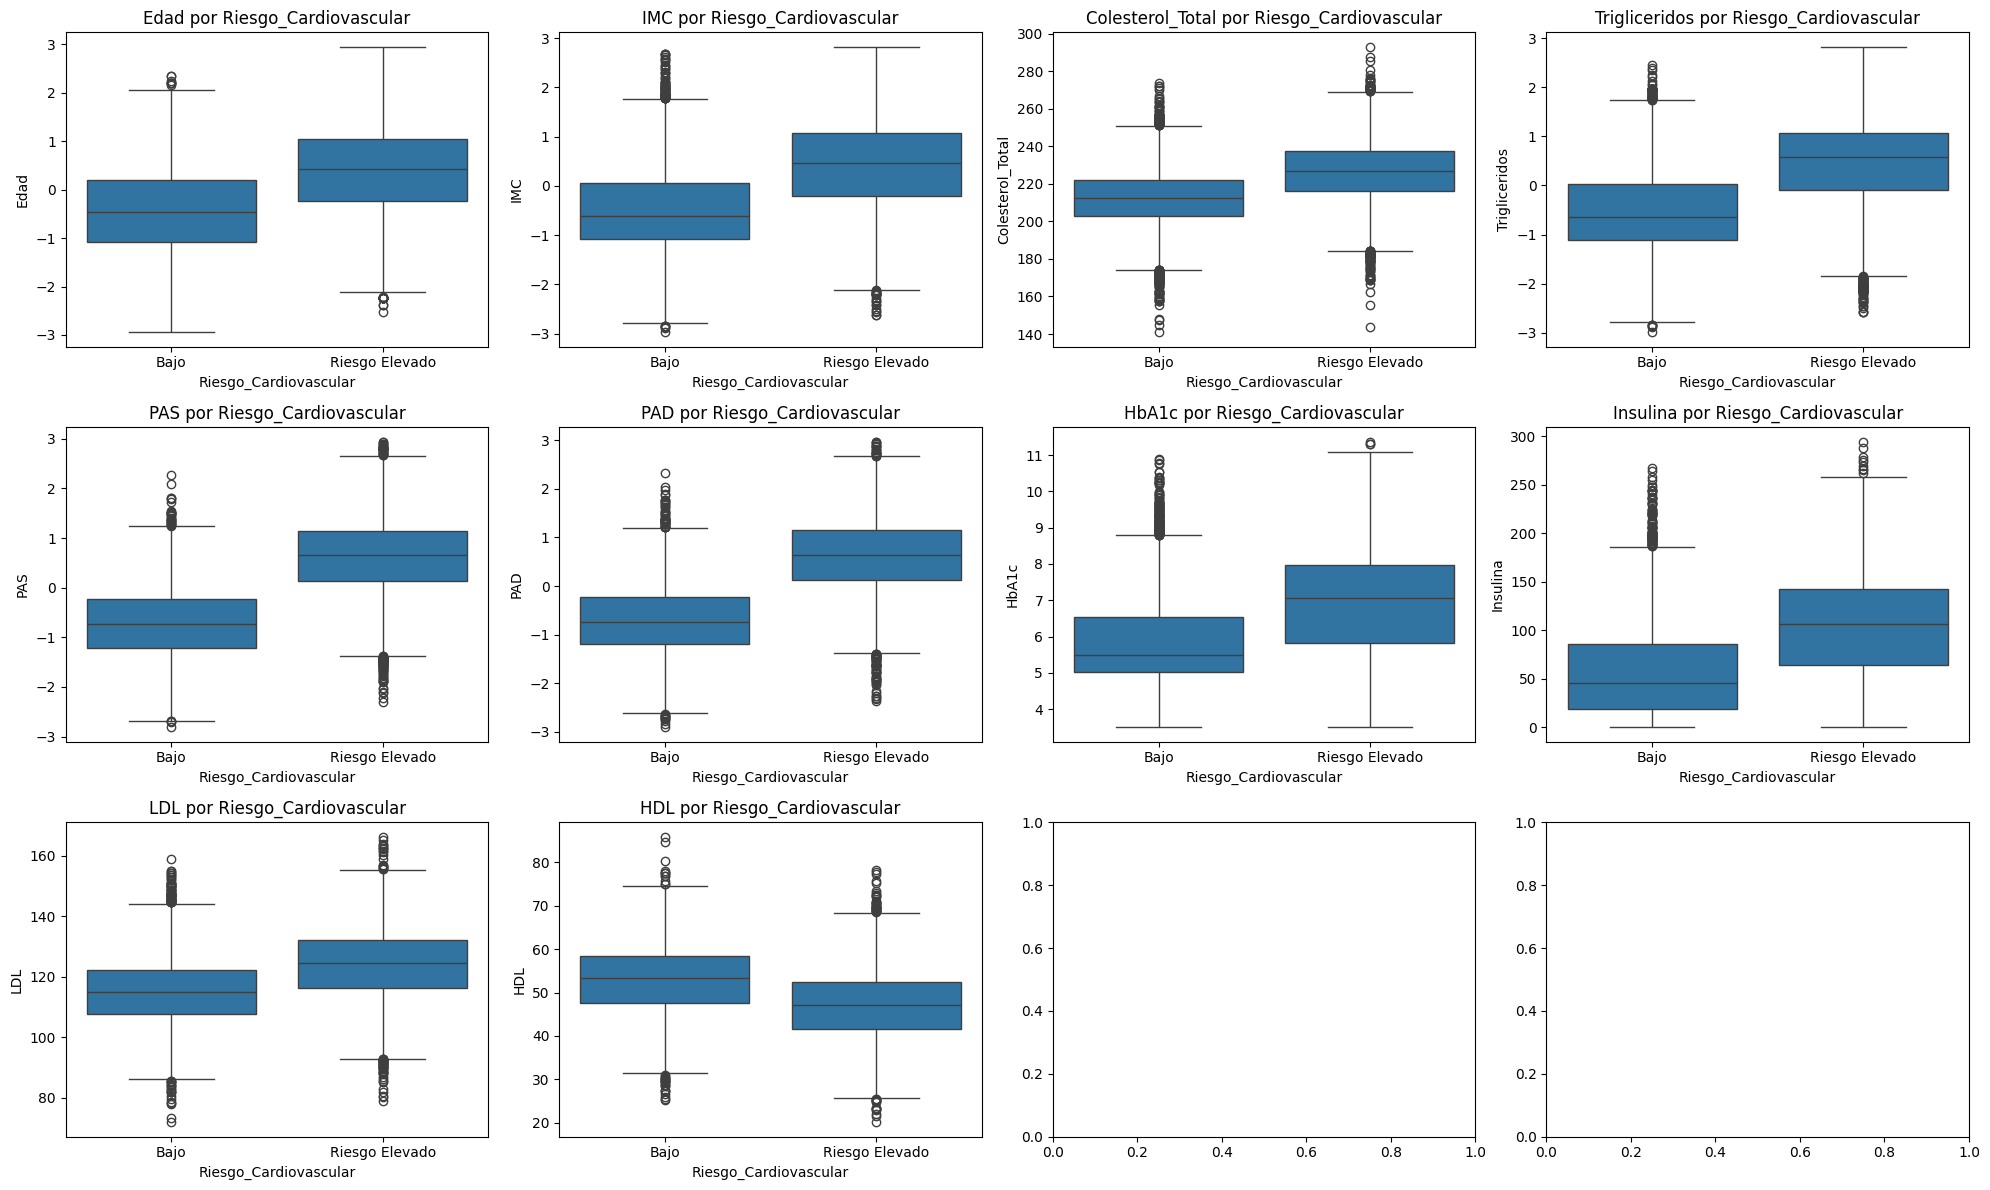

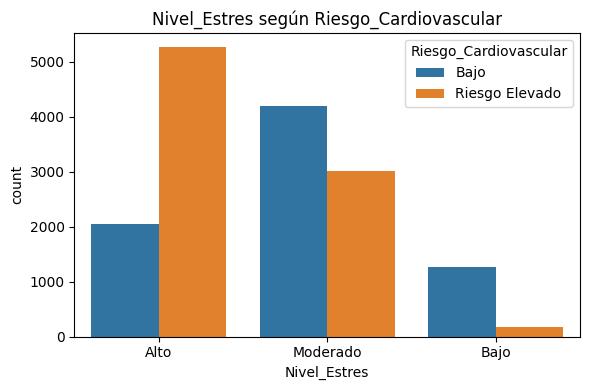

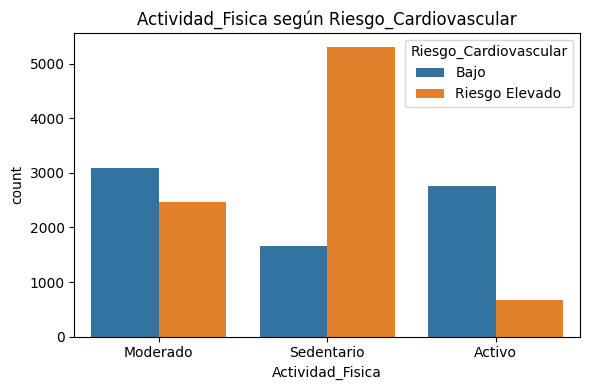

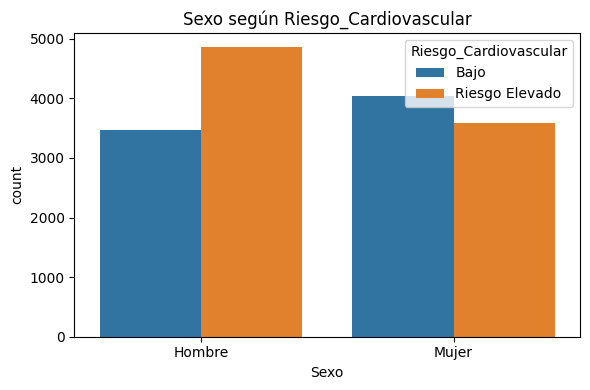

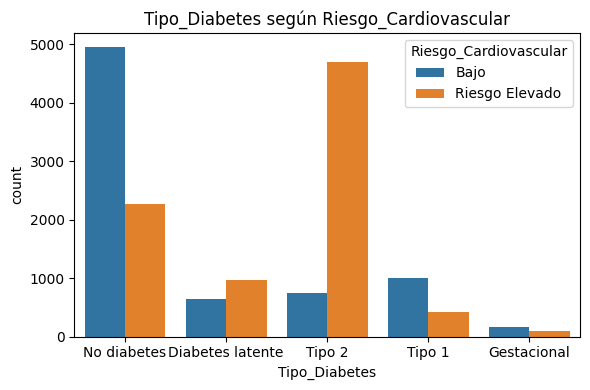

In [18]:
# Seleccionamos solo las filas donde Riesgo_Cardiovascular no es nulo
df_viz = df[df['Riesgo_Cardiovascular'].notnull()]

features_numericas = ['Edad', 'IMC', 'Colesterol_Total', 'Trigliceridos', 'PAS', 'PAD', 'HbA1c', 'Insulina', 'LDL', 'HDL']
features_categoricas = ['Nivel_Estres', 'Actividad_Fisica', 'Sexo', 'Tipo_Diabetes']

# Variables numéricas
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 12))
axes = axes.flatten()
for i, col in enumerate(features_numericas):
    sns.boxplot(data=df_viz, x='Riesgo_Cardiovascular', y=col, ax=axes[i])
    axes[i].set_title(f'{col} por Riesgo_Cardiovascular')
plt.tight_layout()
plt.show()

# Variables categóricas
for col in features_categoricas:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df_viz, x=col, hue='Riesgo_Cardiovascular')
    plt.title(f'{col} según Riesgo_Cardiovascular')
    plt.legend(title='Riesgo_Cardiovascular')
    plt.tight_layout()
    plt.show()

In [19]:
# Guardar el DataFrame df en un archivo CSV
df.to_csv("db_cardiabetes.csv", index=False)
print("Base de datos guardada como 'db_cardiabetes.csv'")

Base de datos guardada como 'db_cardiabetes.csv'
